# Need to check the problem with plate locations search fillna 

In [1]:
import pandas as pd
import requests
import os
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpdz
import geopandas as gpd
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Set Up the URL 
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime": "2022-04-01",
    "endtime": "2024-12-31",
    "minmagnitude": 4.5,
}

# Send the Request and Check the Response
response = requests.get(url, params=params)
print(f"Response Status Code: {response.status_code}")
if response.status_code == 200:
    earthquake_data = response.json()
    print("Number of earthquakes:", len(earthquake_data["features"]))
    print("First earthquake:", earthquake_data["features"][0])
elif response.status_code == 400:
    print("Bad Request Error: Check URL and parameters")
    print(response.text)  # Print the full response text for debugging
else:
    print("Error:", response.status_code)

# Ensure the DataFrame df is only created if the response is successful
if response.status_code == 200:
    # Parse the GeoJSON Data and Extract Information
    earthquake_list = []
    for feature in earthquake_data["features"]:
        earthquake = {
            "type": feature["type"],
            "geometry": feature["geometry"],
            "id": feature["id"]
        }
        for key, value in feature["properties"].items():
            earthquake[key] = value
        earthquake_list.append(earthquake)
    df = pd.DataFrame(earthquake_list)
else:
    print("DataFrame 'df' is not defined. Check for issues in the data extraction steps.")

Response Status Code: 200
Number of earthquakes: 19601
First earthquake: {'type': 'Feature', 'properties': {'mag': 4.6, 'place': '80 km NW of Kandrian, Papua New Guinea', 'time': 1735602989977, 'updated': 1737523819040, 'tz': None, 'url': 'https://earthquake.usgs.gov/earthquakes/eventpage/us6000pgkh', 'detail': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us6000pgkh&format=geojson', 'felt': None, 'cdi': None, 'mmi': None, 'alert': None, 'status': 'reviewed', 'tsunami': 0, 'sig': 326, 'net': 'us', 'code': '6000pgkh', 'ids': ',us6000pgkh,', 'sources': ',us,', 'types': ',origin,phase-data,', 'nst': 47, 'dmin': 3.367, 'rms': 0.44, 'gap': 109, 'magType': 'mb', 'type': 'earthquake', 'title': 'M 4.6 - 80 km NW of Kandrian, Papua New Guinea'}, 'geometry': {'type': 'Point', 'coordinates': [148.9729, -5.7603, 127.013]}, 'id': 'us6000pgkh'}


In [3]:
# Extract Latitude, Longitude, and Depth from geometry
if 'df' in locals():
    df['latitude'] = df['geometry'].apply(lambda x: x['coordinates'][1])
    df['longitude'] = df['geometry'].apply(lambda x: x['coordinates'][0])
    df['depth'] = df['geometry'].apply(lambda x: x['coordinates'][2])

    # Convert Timestamp to Datetime
    df['time'] = pd.to_datetime(df['time'], unit='ms')

    # Drop the geometry column if no longer needed
    df.drop(columns=['geometry'], inplace=True)

    # Set 'time' as the index
    df.set_index('time', inplace=True)

    # Display DataFrame information
    display(df.info())
else:
    print("DataFrame 'df' is not defined. Check for issues in the data extraction steps.")


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19601 entries, 2024-12-30 23:56:29.977000 to 2022-04-01 01:08:14.815000
Data columns (total 29 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   type       19601 non-null  object 
 1   id         19601 non-null  object 
 2   mag        19601 non-null  float64
 3   place      19601 non-null  object 
 4   updated    19601 non-null  int64  
 5   tz         0 non-null      object 
 6   url        19601 non-null  object 
 7   detail     19601 non-null  object 
 8   felt       3884 non-null   float64
 9   cdi        3884 non-null   float64
 10  mmi        2071 non-null   float64
 11  alert      1807 non-null   object 
 12  status     19601 non-null  object 
 13  tsunami    19601 non-null  int64  
 14  sig        19601 non-null  int64  
 15  net        19601 non-null  object 
 16  code       19601 non-null  object 
 17  ids        19601 non-null  object 
 18  sources    19601 non-null  object 
 1

None

In [4]:
# Ensure 'time' column is retained for feature engineering
df.reset_index(inplace=True)

# Convert DataFrame to GeoDataFrame
def create_geodataframe(df):
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    return gdf

# Create a GeoDataFrame
gdf = create_geodataframe(df)

# Set Coordinate Reference System (CRS)
gdf.set_crs(epsg=4326, inplace=True)

# Path to the extracted shapefile directory
extract_to_path = r'C:\Users\thoma\Documents\GitHub\USGS\Tectonic_Plates_and_Boundaries'
shapefile_path = os.path.join(extract_to_path, 'Tectonic_Plates_and_Boundaries.shp')

# Load the shapefile using GeoPandas
if os.path.exists(shapefile_path):
    tectonic_plates = gpd.read_file(shapefile_path)
    print("Shapefile loaded successfully.")
    display(tectonic_plates.head())
else:
    print("Shapefile not found. Please check the path.")

# Ensure the tectonic plates GeoDataFrame has the same CRS as the earthquake GeoDataFrame
tectonic_plates = tectonic_plates.to_crs(gdf.crs)

# Perform spatial join to associate each earthquake with the corresponding tectonic plate
gdf = gpd.sjoin(gdf, tectonic_plates, how='left', predicate='intersects', lsuffix='left', rsuffix='right')

# Rename the column for clarity
gdf.rename(columns={'Name': 'tectonic_plate'}, inplace=True)

# Verify the results of the renaming
print("Columns after renaming:")
display(gdf.columns)
print("Head of the GeoDataFrame after spatial join:")
display(gdf.head())

# Save the updated GeoDataFrame to a CSV file at the specified location
csv_file_path = r"C:\Users\thoma\Documents\GitHub\USGS\earthquake_data_with_plates.csv"
gdf.to_csv(csv_file_path, index=False)

print(f"Data saved to {csv_file_path}")


Shapefile loaded successfully.


,OBJECTID,Code,PlateName,Shape__Are,Shape__Len,geometry
0,1,AF,Africa,7.321846e+13,4.963234e+07,"POLYGON Z ((-48746.805 -7333156.477 0, -101818..."
1,2,AN,Antarctica,9.350352e+14,1.459012e+08,"POLYGON Z ((-20037507.067 -9808593.925 0, -199..."
2,3,SO,Somalia,2.174794e+13,2.599516e+07,"POLYGON Z ((3576227.697 -5942041.427 0, 357616..."
3,4,IN,India,1.352969e+13,1.809340e+07,"POLYGON Z ((6263413.413 1645813.193 0, 6345377..."
4,5,AU,Australia,6.350938e+13,4.931614e+07,MULTIPOLYGON Z (((-20037507.067 -1760839.892 0...


Columns after renaming:


Index(['time', 'type', 'id', 'mag', 'place', 'updated', 'tz', 'url', 'detail',
       'felt', 'cdi', 'mmi', 'alert', 'status', 'tsunami', 'sig', 'net',
       'code', 'ids', 'sources', 'types', 'nst', 'dmin', 'rms', 'gap',
       'magType', 'title', 'latitude', 'longitude', 'depth', 'geometry',
       'index_right', 'OBJECTID', 'Code', 'PlateName', 'Shape__Are',
       'Shape__Len'],
      dtype='object')

Head of the GeoDataFrame after spatial join:


,time,type,id,mag,place,updated,tz,url,detail,felt,...,latitude,longitude,depth,geometry,index_right,OBJECTID,Code,PlateName,Shape__Are,Shape__Len
0,2024-12-30 23:56:29.977,earthquake,us6000pgkh,4.6,"80 km NW of Kandrian, Papua New Guinea",1737523819040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,...,-5.7603,148.9729,127.013,POINT (148.9729 -5.7603),19,20,SB,South Bismarck,3.122987e+11,2.798683e+06
1,2024-12-30 23:40:33.868,earthquake,us6000pgkd,4.6,"247 km ENE of Levuka, Fiji",1737523683040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,...,-17.6089,-178.3937,573.817,POINT (-178.3937 -17.6089),4,5,AU,Australia,6.350938e+13,4.931614e+07
2,2024-12-30 23:30:59.974,earthquake,us6000pgkb,4.7,"24 km N of Metahāra, Ethiopia",1737521527845,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,5.0,...,9.1189,39.9276,10.000,POINT (39.9276 9.1189),2,3,SO,Somalia,2.174794e+13,2.599516e+07
3,2024-12-30 22:13:14.697,earthquake,us6000pgjz,4.8,"22 km NW of Āwash, Ethiopia",1738203292040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,6.0,...,9.1373,40.0367,10.000,POINT (40.0367 9.1373),2,3,SO,Somalia,2.174794e+13,2.599516e+07
4,2024-12-30 20:33:11.322,earthquake,us6000pgjf,4.6,"28 km NNW of Āwash, Ethiopia",1736616791040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,...,9.2103,40.0504,10.000,POINT (40.0504 9.2103),2,3,SO,Somalia,2.174794e+13,2.599516e+07


Data saved to C:\Users\thoma\Documents\GitHub\USGS\earthquake_data_with_plates.csv


In [5]:
# Ensure 'time' column is retained for feature engineering
gdf.reset_index(inplace=True)

# Calculate time since last significant earthquake within each tectonic plate
gdf['time_since_last'] = gdf.groupby('tectonic_plate')['time'].diff().dt.days

# Define function to count earthquakes within specified days
def count_earthquakes(df, days):
    end_date = df['time'].max()
    start_date = end_date - pd.Timedelta(days=days)
    filtered_df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]
    return filtered_df.groupby('tectonic_plate')['mag'].count()

# Count number of smaller earthquakes in past 1, 3, and 6 months within each tectonic plate
gdf['count_1m'] = gdf.apply(lambda row: count_earthquakes(gdf[gdf['tectonic_plate'] == row['tectonic_plate']], 30).get(row['tectonic_plate'], 0), axis=1)
gdf['count_3m'] = gdf.apply(lambda row: count_earthquakes(gdf[gdf['tectonic_plate'] == row['tectonic_plate']], 90).get(row['tectonic_plate'], 0), axis=1)
gdf['count_6m'] = gdf.apply(lambda row: count_earthquakes(gdf[gdf['tectonic_plate'] == row['tectonic_plate']], 180).get(row['tectonic_plate'], 0), axis=1)

# Rolling averages of seismic activity within each tectonic plate
def rolling_avg_earthquakes(df, days):
    df['rolling_avg'] = df.groupby('tectonic_plate')['mag'].transform(lambda x: x.rolling(window=days, min_periods=1).mean())
    return df['rolling_avg']

gdf['rolling_avg_3m'] = rolling_avg_earthquakes(gdf, 90)

# Fill NA values with appropriate values (e.g., 0 for counts)
gdf.fillna(0, inplace=True)

# Display DataFrame information
display(gdf.info())

KeyError: 'tectonic_plate'

In [ ]:


# Verify the results of the renaming
display(gdf.columns)
display(gdf.head())

# Save the updated GeoDataFrame to a CSV file at the specified location
csv_file_path = r"C:\Users\thoma\Documents\GitHub\USGS\earthquake_data_with_plates2.csv"
gdf.to_csv(csv_file_path, index=False)

print(f"Data saved to {csv_file_path}")


Index(['index', 'time', 'type', 'id', 'mag', 'place', 'updated', 'tz', 'url',
       'detail', 'felt', 'cdi', 'mmi', 'alert', 'status', 'tsunami', 'sig',
       'net', 'code', 'ids', 'sources', 'types', 'nst', 'dmin', 'rms', 'gap',
       'magType', 'title', 'latitude', 'longitude', 'depth', 'geometry',
       'index_right', 'OBJECTID', 'LAYER', 'tectonic_plate', 'Source',
       'PlateA', 'PlateB', 'Type', 'Shape__Len', 'time_since_last', 'count_1m',
       'count_3m', 'count_6m', 'rolling_avg', 'rolling_avg_3m'],
      dtype='object')

,index,time,type,id,mag,place,updated,tz,url,detail,...,PlateA,PlateB,Type,Shape__Len,time_since_last,count_1m,count_3m,count_6m,rolling_avg,rolling_avg_3m
0,0,2024-12-30 23:56:29.977,earthquake,us6000pgkh,4.6,"80 km NW of Kandrian, Papua New Guinea",1737523819040,0,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,...,0,0,0,0.0,0.0,0,0,0,0.0,0.0
1,1,2024-12-30 23:40:33.868,earthquake,us6000pgkd,4.6,"247 km ENE of Levuka, Fiji",1737523683040,0,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,...,0,0,0,0.0,0.0,0,0,0,0.0,0.0
2,2,2024-12-30 23:30:59.974,earthquake,us6000pgkb,4.7,"24 km N of Metahāra, Ethiopia",1737521527845,0,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,...,0,0,0,0.0,0.0,0,0,0,0.0,0.0
3,3,2024-12-30 22:13:14.697,earthquake,us6000pgjz,4.8,"22 km NW of Āwash, Ethiopia",1738203292040,0,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,...,0,0,0,0.0,0.0,0,0,0,0.0,0.0
4,4,2024-12-30 20:33:11.322,earthquake,us6000pgjf,4.6,"28 km NNW of Āwash, Ethiopia",1736616791040,0,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,...,0,0,0,0.0,0.0,0,0,0,0.0,0.0


Data saved to C:\Users\thoma\Documents\GitHub\USGS\earthquake_data_with_plates2.csv


# Preprocess

# Generate SARIMA Feature

In [ ]:
# Prepare Time Series Data for SARIMA
# Aggregate earthquake data by month for each tectonic plate
gdf['year_month'] = gdf['time'].dt.to_period('M')
monthly_counts = gdf.groupby(['tectonic_plate', 'year_month']).size().unstack(fill_value=0)

# Fit SARIMA model for each tectonic plate
sarima_forecasts = {}
for plate in monthly_counts.index:
    ts_data = monthly_counts.loc[plate]
    model = SARIMAX(ts_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results = model.fit(disp=False)
    forecast = results.get_forecast(steps=12)  # Forecast next 12 months
    sarima_forecasts[plate] = forecast.predicted_mean

# Add SARIMA forecast as a new feature
for plate, forecast in sarima_forecasts.items():
    gdf.loc[gdf['tectonic_plate'] == plate, 'sarima_forecast'] = forecast.values[-1]

# Ensure SARIMA forecast feature is filled for all rows
#gdf['sarima_forecast'].fillna(0, inplace=True)

# Display updated DataFrame information
display(gdf.columns)

C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Index(['index', 'time', 'type', 'id', 'mag', 'place', 'updated', 'tz', 'url',
       'detail', 'felt', 'cdi', 'mmi', 'alert', 'status', 'tsunami', 'sig',
       'net', 'code', 'ids', 'sources', 'types', 'nst', 'dmin', 'rms', 'gap',
       'magType', 'title', 'latitude', 'longitude', 'depth', 'geometry',
       'index_right', 'OBJECTID', 'LAYER', 'tectonic_plate', 'Source',
       'PlateA', 'PlateB', 'Type', 'Shape__Len', 'time_since_last', 'count_1m',
       'count_3m', 'count_6m', 'rolling_avg', 'rolling_avg_3m', 'year_month',
       'sarima_forecast'],
      dtype='object')

# Generate Targets

In [ ]:
# Define a function to create the target variable for prediction within the next month
threshold_magnitude = 5.0 
def create_target_within_next_month(df, threshold_magnitude):
    df['next_month'] = df['time'] + pd.DateOffset(months=1)
    df['target_next_month'] = df.apply(lambda row: 1 if (df[(df['time'] >= row['time']) & (df['time'] <= row['next_month']) & (df['mag'] >= threshold_magnitude)].shape[0] > 0) else 0, axis=1)
    return df

gdf = create_target_within_next_month(gdf, threshold_magnitude)

# Define a function to create the target variable for prediction within the next 6 months
def create_target_within_next_6_months(df, threshold_magnitude):
    df['next_6_months'] = df['time'] + pd.DateOffset(months=6)
    df['target_next_6_months'] = df.apply(lambda row: 1 if (df[(df['time'] > row['time']) & (df['time'] <= row['next_6_months']) & (df['mag'] >= threshold_magnitude)].shape[0] > 0) else 0, axis=1)
    return df

# Apply the function to create the target variable
gdf = create_target_within_next_6_months(gdf, threshold_magnitude)


# EDA

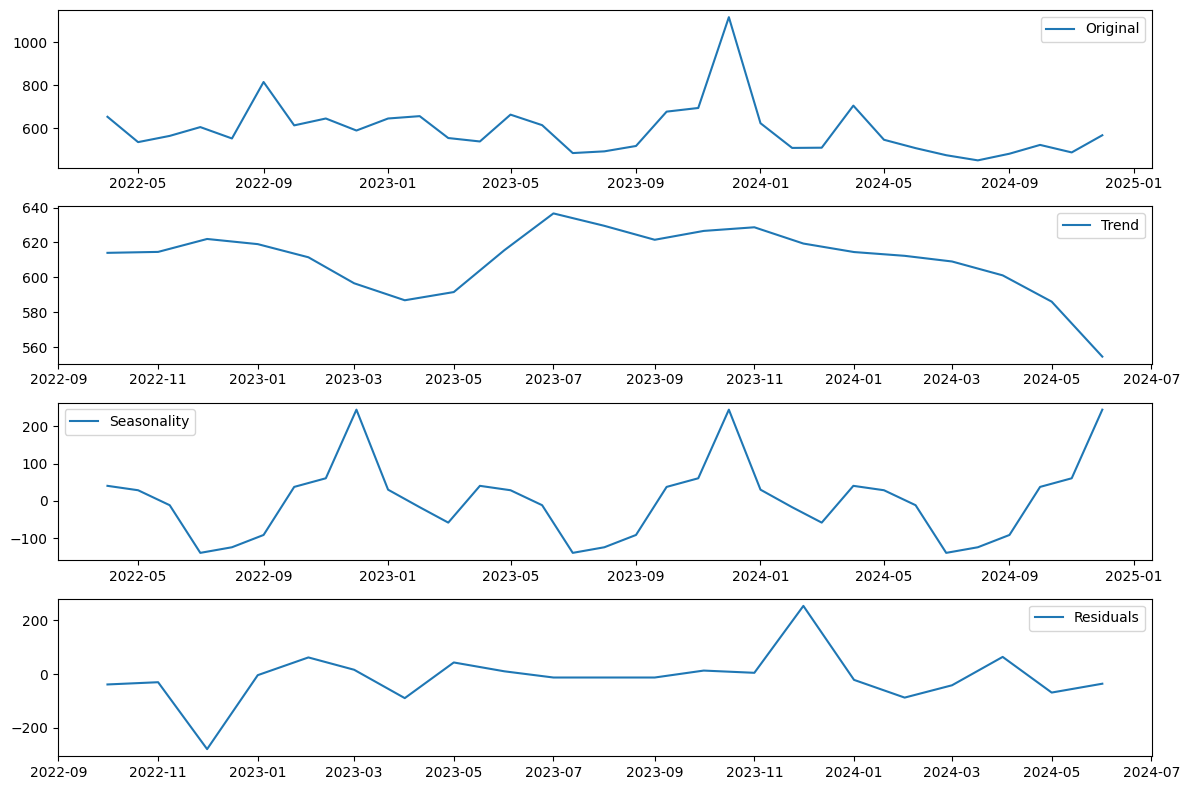

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Convert 'time' column to datetime if not already
gdf['time'] = pd.to_datetime(gdf['time'], errors='coerce')

# Aggregate earthquake data by month
gdf['year_month'] = gdf['time'].dt.to_period('M')
monthly_counts = gdf.groupby('year_month').size()

# Ensure the data is sorted by time
monthly_counts = monthly_counts.sort_index()

# Convert PeriodIndex to DatetimeIndex for plotting
monthly_counts.index = monthly_counts.index.to_timestamp()

# Specify the period (e.g., 12 for monthly data)
decomposition = seasonal_decompose(monthly_counts, model='additive', period=12)

# Extract the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(monthly_counts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()



In [ ]:
# One-Hot Encoding for Categorical Features
categorical_features = ['magType', 'Type']

# Perform One-Hot Encoding
gdf_encoded = pd.get_dummies(gdf, columns=categorical_features)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score


# Define features and target variable again with encoded columns
features = ['time_since_last', 'count_1m', 'count_3m', 'count_6m', 'rolling_avg_3m', 'latitude', 'longitude', 'sarima_forecast', 'depth', 'sig', 'dmin', 'rms', 'gap', 'Shape__Len'] + list(gdf_encoded.columns[gdf_encoded.columns.str.startswith(tuple(categorical_features))])
X = gdf_encoded[features]
y = gdf_encoded['target_next_month']  # Updated target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_test)
y_prob_gb = gb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_gb = accuracy_score(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, y_prob_gb)

print("Gradient Boosting Accuracy (Next Month):", round(accuracy_gb, 3))
print("Gradient Boosting ROC-AUC Score (Next Month):", round(roc_auc_gb, 3))

# Feature Importance
importances_gb = gb_model.feature_importances_
feature_names = features

# Create a DataFrame for better visualization
feature_importance_df_gb = pd.DataFrame({'Feature': feature_names, 'Importance': importances_gb})
feature_importance_df_gb = feature_importance_df_gb.sort_values(by='Importance', ascending=False)

print("Gradient Boosting Feature Importance (Next Month):")
print(feature_importance_df_gb)



Gradient Boosting Accuracy (Next Month): 0.992
Gradient Boosting ROC-AUC Score (Next Month): 0.455
Gradient Boosting Feature Importance (Next Month):
               Feature  Importance
12                 gap    0.745350
11                 rms    0.207533
10                dmin    0.023527
22         magType_mwr    0.016004
6            longitude    0.004215
5             latitude    0.002517
8                depth    0.000832
9                  sig    0.000021
16          magType_ml    0.000000
23         magType_mww    0.000000
21         magType_mwp    0.000000
20         magType_mwc    0.000000
19         magType_mwb    0.000000
18          magType_mw    0.000000
17  magType_ml(texnet)    0.000000
0      time_since_last    0.000000
15          magType_md    0.000000
14          magType_mb    0.000000
13          Shape__Len    0.000000
1             count_1m    0.000000
7      sarima_forecast    0.000000
4       rolling_avg_3m    0.000000
3             count_6m    0.000000
2         

# Model

In [ ]:
# Check the unique values in PlateA and PlateB columns
print("Unique values in PlateA column:")
print(gdf_encoded['PlateA'].unique())

print("Unique values in PlateB column:")
print(gdf_encoded['PlateB'].unique())

# Print the first few rows of PlateA and PlateB columns
print("PlateA Column Head:")
print(gdf_encoded[['PlateA']].head(10))

print("PlateB Column Head:")
print(gdf_encoded[['PlateB']].head(10))


Unique values in PlateA column:
[0]
Unique values in PlateB column:
[0]
PlateA Column Head:
   PlateA
0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
PlateB Column Head:
   PlateB
0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

In [ ]:
# select magnitude 
threshold_magnitude = 5.0

In [ ]:
# Filter Plate
plate = 'Indian' 
def filter_tectonic_plate(gdf_encoded, plate_name):
    return gdf_encoded[gdf_encoded['tectonic_plate'] == plate_name]

# Apply the filter function to select data for the Indian Plate
gdf_encoded_indian_plate = filter_tectonic_plate(gdf_encoded, plate)


In [ ]:
# Define features and target variables again with encoded columns
features = ['time_since_last', 'count_1m', 'count_3m', 'count_6m', 'rolling_avg_3m', 'latitude', 'longitude', 'sarima_forecast', 'depth', 'sig', 'dmin', 'rms', 'gap', 'Shape__Len'] + list(gdf_encoded.columns[gdf_encoded.columns.str.startswith(tuple(categorical_features))])
X = gdf_encoded[features]
y = gdf_encoded['target_next_6_months']  # Target for next 6 months
z = gdf_encoded['target_next_month']  # Target for next month

# Split data for 6 months
X_train_y, X_test_y, y_train_y, y_test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Split data next month
X_train_z, X_test_z, y_train_z, y_test_z = train_test_split(X, z, test_size=0.2, random_state=42)


In [ ]:
#6 months Logistics
log_reg_model_y = LogisticRegression(random_state=42)
log_reg_model_y.fit(X_train_y, y_train_y)

# Make predictions for target y
y_pred_log_reg_y = log_reg_model_y.predict(X_test_y)
y_prob_log_reg_y = log_reg_model_y.predict_proba(X_test_y)[:, 1]

# Evaluate the model for target y
accuracy_log_reg_y = accuracy_score(y_test_y, y_pred_log_reg_y)
roc_auc_log_reg_y = roc_auc_score(y_test_y, y_prob_log_reg_y)

print("Logistic Regression Accuracy (Next 6 Months):", round(accuracy_log_reg_y, 3))
print("Logistic Regression ROC-AUC Score (Next 6 Months):", round(roc_auc_log_reg_y, 3))


Logistic Regression Accuracy (Next 6 Months): 0.999
Logistic Regression ROC-AUC Score (Next 6 Months): 0.661


In [ ]:
# next month Logistics
log_reg_model_z = LogisticRegression(random_state=42)
log_reg_model_z.fit(X_train_z, y_train_z)

# Make predictions for target z
y_pred_log_reg_z = log_reg_model_z.predict(X_test_z)
y_prob_log_reg_z = log_reg_model_z.predict_proba(X_test_z)[:, 1]

# Evaluate the model for target z
accuracy_log_reg_z = accuracy_score(y_test_z, y_pred_log_reg_z)
roc_auc_log_reg_z = roc_auc_score(y_test_z, y_prob_log_reg_z)

print("Logistic Regression Accuracy (Next Month):", round(accuracy_log_reg_z, 3))
print("Logistic Regression ROC-AUC Score (Next Month):", round(roc_auc_log_reg_z, 3))

Logistic Regression Accuracy (Next Month): 0.999
Logistic Regression ROC-AUC Score (Next Month): 0.722


In [ ]:
#6 months gradient boost
gb_model_y = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model_y.fit(X_train_y, y_train_y)

# Make predictions
y_pred_gb_y = gb_model_y.predict(X_test_y)
y_prob_gb_y = gb_model_y.predict_proba(X_test_y)[:, 1]

# Evaluate the model
accuracy_gb_y = accuracy_score(y_test_y, y_pred_gb_y)
roc_auc_gb_y = roc_auc_score(y_test_y, y_prob_gb_y)

print("Gradient Boosting Accuracy (Next 6 Months):", round(accuracy_gb_y, 3))
print("Gradient Boosting ROC-AUC Score (Next 6 Months):", round(roc_auc_gb_y, 3))



Gradient Boosting Accuracy (Next 6 Months): 0.992
Gradient Boosting ROC-AUC Score (Next 6 Months): 0.558


In [ ]:
# next month gradient boost
gb_model_z = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model_z.fit(X_train_z, y_train_z)

# Make predictions
y_pred_gb_z = gb_model_z.predict(X_test_z)
y_prob_gb_z = gb_model_z.predict_proba(X_test_z)[:, 1]

# Evaluate the model
accuracy_gb_z = accuracy_score(y_test_z, y_pred_gb_z)
roc_auc_gb_z = roc_auc_score(y_test_z, y_prob_gb_z)

print("Gradient Boosting Accuracy (Next Month):", round(accuracy_gb_z, 3))
print("Gradient Boosting ROC-AUC Score (Next Month):", round(roc_auc_gb_z, 3))


Gradient Boosting Accuracy (Next Month): 0.992
Gradient Boosting ROC-AUC Score (Next Month): 0.455


In [ ]:
#6 months gradient cat boost
catboost_model_y = CatBoostClassifier(iterations=100, random_state=42, verbose=0)
catboost_model_y.fit(X_train_y, y_train_y)

# Make predictions
y_pred_cb_y = catboost_model_y.predict(X_test_y)
y_prob_cb_y = catboost_model_y.predict_proba(X_test_y)[:, 1]

# Evaluate the CatBoost model
accuracy_cb_y = accuracy_score(y_test_y, y_pred_cb_y)
roc_auc_cb_y = roc_auc_score(y_test_y, y_prob_cb_y)

print("CatBoost Accuracy (Next 6 Months):", round(accuracy_cb_y, 3))
print("CatBoost ROC-AUC Score (Next 6 Months):", round(roc_auc_cb_y, 3))


CatBoost Accuracy (Next 6 Months): 0.999
CatBoost ROC-AUC Score (Next 6 Months): 0.905


In [ ]:
# next months gradient cat boost
catboost_model_z = CatBoostClassifier(iterations=100, random_state=42, verbose=0)
catboost_model_z.fit(X_train_z, y_train_z)

# Make predictions
y_pred_cb_z = catboost_model_z.predict(X_test_z)
y_prob_cb_z = catboost_model_z.predict_proba(X_test_z)[:, 1]

# Evaluate the CatBoost model
accuracy_cb_z = accuracy_score(y_test_z, y_pred_cb_z)
roc_auc_cb_z = roc_auc_score(y_test_z, y_prob_cb_z)

print("CatBoost Accuracy (Next Month):", round(accuracy_cb_z, 3))
print("CatBoost ROC-AUC Score (Next Month):", round(roc_auc_cb_z, 3))


CatBoost Accuracy (Next Month): 0.999
CatBoost ROC-AUC Score (Next Month): 0.926


# Plate selection

In [ ]:


def filter_tectonic_plate(gdf_encoded, plate_name):
    return gdf_encoded[gdf_encoded['tectonic_plate'] == plate_name]

# Apply the filter function to select data for the Indian Plate
plate = 'Indian'
gdf_encoded_indian_plate = filter_tectonic_plate(gdf_encoded, plate)

# Verify the filtered data
print("Filtered Data for Indian Plate:")
print(gdf_encoded_indian_plate['tectonic_plate'].unique())
print(gdf_encoded_indian_plate.head())


Filtered Data for Indian Plate:
[]
Empty GeoDataFrame
Columns: [index, time, type, id, mag, place, updated, tz, url, detail, felt, cdi, mmi, alert, status, tsunami, sig, net, code, ids, sources, types, nst, dmin, rms, gap, title, latitude, longitude, depth, geometry, index_right, OBJECTID, LAYER, tectonic_plate, Source, PlateA, PlateB, Shape__Len, time_since_last, count_1m, count_3m, count_6m, rolling_avg, rolling_avg_3m, year_month, sarima_forecast, next_month, target_next_month, next_6_months, target_next_6_months, magType_mb, magType_md, magType_ml, magType_ml(texnet), magType_mw, magType_mwb, magType_mwc, magType_mwp, magType_mwr, magType_mww, Type_0]
Index: []

[0 rows x 62 columns]


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

threshold_magnitude = 5.0

# Filter Plate
plate = 'Indian'
def filter_tectonic_plate(gdf_encoded, plate_name):
    return gdf_encoded[gdf_encoded['tectonic_plate'] == plate_name]

# Apply the filter function to select data for the Indian Plate
gdf_encoded_indian_plate = filter_tectonic_plate(gdf_encoded, plate)

# Verify the filtered data
print("Filtered Data for Indian Plate:")
print(gdf_encoded_indian_plate['tectonic_plate'].unique())
print(gdf_encoded_indian_plate.head())

# Confirm the size of the filtered dataset
print("Size of Filtered Dataset:", gdf_encoded_indian_plate.shape)

# Ensure columns are correctly referenced
categorical_features = ['magType', 'Type']

# Define features and target variables again with encoded columns for the Indian Plate
features = ['time_since_last', 'count_1m', 'count_3m', 'count_6m', 'rolling_avg_3m', 'latitude', 'longitude', 'sarima_forecast', 'depth', 'sig', 'dmin', 'rms', 'gap', 'Shape__Len'] + list(gdf_encoded_indian_plate.columns[gdf_encoded_indian_plate.columns.str.startswith(tuple(categorical_features))])
X = gdf_encoded_indian_plate[features]
y = gdf_encoded_indian_plate['target_next_6_months']  # Target for next 6 months
z = gdf_encoded_indian_plate['target_next_month']  # Target for next month

# Print the first few rows of X, y, and z to ensure they are correctly defined
print("Features (X) Head:")
print(X.head())
print("Target (y) Head:")
print(y.head())
print("Target (z) Head:")
print(z.head())

# Split data for 6 months
X_train_y, X_test_y, y_train_y, y_test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Split data next month
X_train_z, X_test_z, y_train_z, y_test_z = train_test_split(X, z, test_size=0.2, random_state=42)

# Train and evaluate models for target y (next 6 months)
# Logistic Regression for y
log_reg_model_y = LogisticRegression(random_state=42)
log_reg_model_y.fit(X_train_y, y_train_y)
y_pred_log_reg_y = log_reg_model_y.predict(X_test_y)
y_prob_log_reg_y = log_reg_model_y.predict_proba(X_test_y)[:, 1]
accuracy_log_reg_y = accuracy_score(y_test_y, y_pred_log_reg_y)
roc_auc_log_reg_y = roc_auc_score(y_test_y, y_prob_log_reg_y)
print("Logistic Regression Accuracy (Next 6 Months):", round(accuracy_log_reg_y, 3))
print("Logistic Regression ROC-AUC Score (Next 6 Months):", round(roc_auc_log_reg_y, 3))

# Gradient Boosting for y
gb_model_y = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model_y.fit(X_train_y, y_train_y)
y_pred_gb_y = gb_model_y.predict(X_test_y)
y_prob_gb_y = gb_model_y.predict_proba(X_test_y)[:, 1]
accuracy_gb_y = accuracy_score(y_test_y, y_pred_gb_y)
roc_auc_gb_y = roc_auc_score(y_test_y, y_prob_gb_y)
print("Gradient Boosting Accuracy (Next 6 Months):", round(accuracy_gb_y, 3))
print("Gradient Boosting ROC-AUC Score (Next 6 Months):", round(roc_auc_gb_y, 3))

# CatBoost for y
catboost_model_y = CatBoostClassifier(iterations=100, random_state=42, verbose=0)
catboost_model_y.fit(X_train_y, y_train_y)
y_pred_cb_y = catboost_model_y.predict(X_test_y)
y_prob_cb_y = catboost_model_y.predict_proba(X_test_y)[:, 1]
accuracy_cb_y = accuracy_score(y_test_y, y_pred_cb_y)
roc_auc_cb_y = roc_auc_score(y_test_y, y_prob_cb_y)
print("CatBoost Accuracy (Next 6 Months):", round(accuracy_cb_y, 3))
print("CatBoost ROC-AUC Score (Next 6 Months):", round(roc_auc_cb_y, 3))

# Train and evaluate models for target z (next month)
# Logistic Regression for z
log_reg_model_z = LogisticRegression(random_state=42)
log_reg_model_z.fit(X_train_z, y_train_z)
y_pred_log_reg_z = log_reg_model_z.predict(X_test_z)
y_prob_log_reg_z = log_reg_model_z.predict_proba(X_test_z)[:, 1]
accuracy_log_reg_z = accuracy_score(y_test_z, y_pred_log_reg_z)
roc_auc_log_reg_z = roc_auc_score(y_test_z, y_prob_log_reg_z)
print("Logistic Regression Accuracy (Next Month):", round(accuracy_log_reg_z, 3))
print("Logistic Regression ROC-AUC Score (Next Month):", round(roc_auc_log_reg_z, 3))

# Gradient Boosting for z
gb_model_z = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model_z.fit(X_train_z, y_train_z)
y_pred_gb_z = gb_model_z.predict(X_test_z)
y_prob_gb_z = gb_model_z.predict_proba(X_test_z)[:, 1]
accuracy_gb_z = accuracy_score(y_test_z, y_pred_gb_z)
roc_auc_gb_z = roc_auc_score(y_test_z, y_prob_gb_z)
print("Gradient Boosting Accuracy (Next Month):", round(accuracy_gb_z, 3))
print("Gradient Boosting ROC-AUC Score (Next Month):", round(roc_auc_gb_z, 3))

# CatBoost for z
catboost_model_z = CatBoostClassifier(iterations=100, random_state=42, verbose=0)
catboost_model_z.fit(X_train_z, y_train_z)
y_pred_cb_z = catboost_model_z.predict(X_test_z)
y_prob_cb_z = catboost_model_z.predict_proba(X_test_z)[:, 1]
accuracy_cb_z = accuracy_score(y_test_z, y_pred_cb_z)
roc_auc_cb_z = roc_auc_score(y_test_z, y_prob_cb_z)
print("CatBoost Accuracy (Next Month):", round(accuracy_cb_z, 3))
print("CatBoost ROC-AUC Score (Next Month):", round(roc_auc_cb_z, 3))



Filtered Data for Indian Plate:
[]
Empty GeoDataFrame
Columns: [index, time, type, id, mag, place, updated, tz, url, detail, felt, cdi, mmi, alert, status, tsunami, sig, net, code, ids, sources, types, nst, dmin, rms, gap, title, latitude, longitude, depth, geometry, index_right, OBJECTID, LAYER, tectonic_plate, Source, PlateA, PlateB, Shape__Len, time_since_last, count_1m, count_3m, count_6m, rolling_avg, rolling_avg_3m, year_month, sarima_forecast, next_month, target_next_month, next_6_months, target_next_6_months, magType_mb, magType_md, magType_ml, magType_ml(texnet), magType_mw, magType_mwb, magType_mwc, magType_mwp, magType_mwr, magType_mww, Type_0]
Index: []

[0 rows x 62 columns]
Size of Filtered Dataset: (0, 62)
Features (X) Head:
Empty DataFrame
Columns: [time_since_last, count_1m, count_3m, count_6m, rolling_avg_3m, latitude, longitude, sarima_forecast, depth, sig, dmin, rms, gap, Shape__Len, magType_mb, magType_md, magType_ml, magType_ml(texnet), magType_mw, magType_mwb, ma

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.